In [1]:
'''importing the required libraries'''

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline



C:\Users\Software\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
'''Importing the dataset and checking its properties '''
df =  pd.read_csv("PS_20174392719_1491204439457_log.csv")



In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
'''Checking for any null values'''
print('Null Values =',df.isnull().values.any())

Null Values = False


In [7]:
#Transaction hour Extracting the hour information.
# transaction hour
df['transactionHour'] = df['step'] % 24

# converting into object type
df['transactionHour'] = df['transactionHour'].astype('object')

In [8]:
#Making the transaction amount units to thousands.
df['th_amount'] = df['amount'] / 1000

In [9]:
#Deriving a label to denote whether the transfer happened from Customer to Merchant or from Customer to Customer.
#transaction type
df['transactionBetween'] = df['nameDest'].apply(lambda x: 'Customer2Customer' if x[0] == "C" else 'Customer2Merchant')

In [10]:
#Categorizing the hour value into peak hour, mid hour, and least hour based on the proportion of fraud happening.
# transaction period
df['transactionPeriod'] = df['transactionHour'].apply(lambda x: 'Peak' if x in [2,3,4,5,6] else
                                                                ('Mid' if x in [22,23,0,1,7,8] else 'Safe'))
#df['transactionPeriod']

Manually calculating the error in origin account balance amount after transaction.

Error = (New Balance + Transaction Amount) - Old Balance

If,
* Transaction Amount = (Old Balance - New Balance), then zero error value.
* Transaction Amount > (Old Balance - New Balance), then negative value.
* Transaction Amount < (Old Balance - New Balance), then positive value.

In [11]:
# origin balance error
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']

In [12]:
'''removing the unwanted features'''
#df.drop('nameOrig', axis=1, inplace=True)
#df.drop('nameDest', axis=1, inplace=True)
#df.drop('isFlaggedFraud', axis=1, inplace=True) 

'removing the unwanted features'

In [13]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transactionHour,th_amount,transactionBetween,transactionPeriod,errorBalanceOrig
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,1,9.83964,Customer2Merchant,Mid,0.00
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,1,1.86428,Customer2Merchant,Mid,0.00
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,1,0.18100,Customer2Customer,Mid,0.00
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,1,0.18100,Customer2Customer,Mid,0.00
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,1,11.66814,Customer2Merchant,Mid,0.00
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,1,7.81771,Customer2Merchant,Mid,0.00
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,1,7.10777,Customer2Merchant,Mid,0.00
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,1,7.86164,Customer2Merchant,Mid,0.00
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,1,4.02436,Customer2Merchant,Mid,1353.36
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,1,5.33777,Customer2Customer,Mid,0.00


Error in destination account balance amount
Manually calculating the error in destination account balance amount after transaction.

Error = (Old Balance + Transaction Amount) - New Balance

If,
* Transaction Amount = (New Balance - Old Balance), then zero error value.
* Transaction Amount > (New Balance - Old Balance), then positive value.
* Transaction Amount < (New Balance - Old Balance), then negative value.

In [14]:
# destination balance error
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

In [15]:
# flag to indicate whether both old and new balance in origin account are zero
df['zeroBalanceOrig'] = df['oldbalanceOrg'] + df['newbalanceOrig']
df['zeroBalanceOrig'] = df['zeroBalanceOrig'].apply(lambda x: 1 if x == 0 else 0)

In [16]:
# flag to indicate whether both old and new balance in destination account are zero
df['zeroBalanceDest'] = df['oldbalanceDest'] + df['newbalanceDest']
df['zeroBalanceDest'] = df['zeroBalanceDest'].apply(lambda x: 1 if x == 0 else 0)

Customer to Merchant transactions are Payment type only.
Remaining transaction types are between Customer to Customer only.

In [17]:
# subsetting fraudulent transactions
df_fraud = df[df['isFraud'] == 1].drop(columns=['isFlaggedFraud'])

# subsetting non-fraudulent transactions
df_nonfraud = df[(df['isFraud'] == 0) & (df['type'].isin(['CASH_OUT','TRANSFER']))].drop(columns=['isFlaggedFraud'])

# creating a new dataframe from sub-sampled data
df_new = pd.concat([df_fraud, df_nonfraud], axis=0)

# dataframe dimensions
print(f"The new sub-sampled dataframe has {df_new.shape[0]} rows and {df_new.shape[1]} columns.")
df_new.head()

The new sub-sampled dataframe has 2770409 rows and 18 columns.


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,transactionHour,th_amount,transactionBetween,transactionPeriod,errorBalanceOrig,errorBalanceDest,zeroBalanceOrig,zeroBalanceDest
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,1,0.181,Customer2Customer,Mid,0.0,181.0,0,1
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,1,0.181,Customer2Customer,Mid,0.0,21363.0,0,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,1,2.806,Customer2Customer,Mid,0.0,2806.0,0,1
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,1,2.806,Customer2Customer,Mid,0.0,29008.0,0,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,1,20.128,Customer2Customer,Mid,0.0,20128.0,0,1


In [18]:
# min and max fraud transaction amount
print("Min fraud transaction amount:", df_fraud['amount'].min());print()
print("Max fraud transaction amount:", df_fraud['amount'].max())

Min fraud transaction amount: 0.0

Max fraud transaction amount: 10000000.0


In [19]:
# no. of fraud transactions per destination account
df_fraud.groupby('nameDest').size().value_counts().reset_index().rename(columns={'index':'No. of Fraudulent Transactions per Destination Account',
                                                                                 0:'No. of Unique Accounts'})

,No. of Fraudulent Transactions per Destination Account,No. of Unique Accounts
0,1,8125
1,2,44


In [20]:
df_fraud.shape[0]

8213

In [21]:
# zero old and new destination balance, but with non-zero transaction amount
print("Proportion of fraudulent transactions where transaction amount is non-zero, but both old balance and new balance in destination account are zero:",
      sum((df_fraud['oldbalanceDest'] == 0) & (df_fraud['newbalanceDest'] == 0) & (df_fraud['amount'] != 0)) / df_fraud.shape[0])
print()
print("Proportion of non fraudulent transactions where transaction amount is non-zero, but both old balance and new balance in destination account are zero:",
      sum((df_nonfraud['oldbalanceDest'] == 0) & (df_nonfraud['newbalanceDest'] == 0) & (df_nonfraud['amount'] != 0)) / df_nonfraud.shape[0])

Proportion of fraudulent transactions where transaction amount is non-zero, but both old balance and new balance in destination account are zero: 0.4955558261293072

Proportion of non fraudulent transactions where transaction amount is non-zero, but both old balance and new balance in destination account are zero: 0.0006176245277308345


In [22]:
# error in origin account balance
print("Proportion of fraudulent transactions where transaction amount is non-zero, and there is an error in origin account balance amount:",
      sum((df_fraud['errorBalanceOrig'] != 0) & (df_fraud['amount'] != 0)) / df_fraud.shape[0])
print()
print("Proportion of non fraudulent transactions where transaction amount is non-zero, and there is an error in origin account balance amount:",
      sum((df_nonfraud['errorBalanceOrig'] != 0) & (df_nonfraud['amount'] != 0)) / df_nonfraud.shape[0])

Proportion of fraudulent transactions where transaction amount is non-zero, and there is an error in origin account balance amount: 0.006940216729575064

Proportion of non fraudulent transactions where transaction amount is non-zero, and there is an error in origin account balance amount: 0.9124529903019192


In [23]:
# error in destination account balance
print("Proportion of fraudulent transactions where transaction amount is non-zero, and there is an error in destination account balance amount:",
      sum((df_fraud['errorBalanceDest'] != 0) & (df_fraud['amount'] != 0)) / df_fraud.shape[0])
print()
print("Proportion of non fraudulent transactions where transaction amount is non-zero, and there is an error in destination account balance amount:",
      sum((df_nonfraud['errorBalanceDest'] != 0) & (df_nonfraud['amount'] != 0)) / df_nonfraud.shape[0])

Proportion of fraudulent transactions where transaction amount is non-zero, and there is an error in destination account balance amount: 0.6482405941799586

Proportion of non fraudulent transactions where transaction amount is non-zero, and there is an error in destination account balance amount: 0.42026706287316323


In [24]:
# average error in origin account balance
print("Average absolute error in origin account balance amount in fraudulent data:", round(abs(df_fraud['errorBalanceOrig']).mean(),2))
print()
print("Average absolute error in origin account balance amount in non fraudulent data:", round(abs(df_nonfraud['errorBalanceOrig']).mean(), 2))

Average absolute error in origin account balance amount in fraudulent data: 10692.33

Average absolute error in origin account balance amount in non fraudulent data: 286803.51


In [25]:
# average error in destination account balance
print("Average absolute error in destination account balance amount in fraudulent data:", round(abs(df_fraud['errorBalanceDest']).mean(), 2))
print()
print("Average absolute error in destination account balance amount in non fraudulent data:", round(abs(df_nonfraud['errorBalanceDest']).mean(), 2))

Average absolute error in destination account balance amount in fraudulent data: 745138.59

Average absolute error in destination account balance amount in non fraudulent data: 44302.66


### Observations:

Fraudulent transactions, in general, are having lower error in origin account balance and higher error in destination account balance at the end of transaction.

Summary statistics:
 count     2770409.00
mean       317536.14
std        887789.66
min             0.00
25%         82973.54
50%        171260.93
75%        306791.18
max      92445516.64
Name: amount, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  21.93


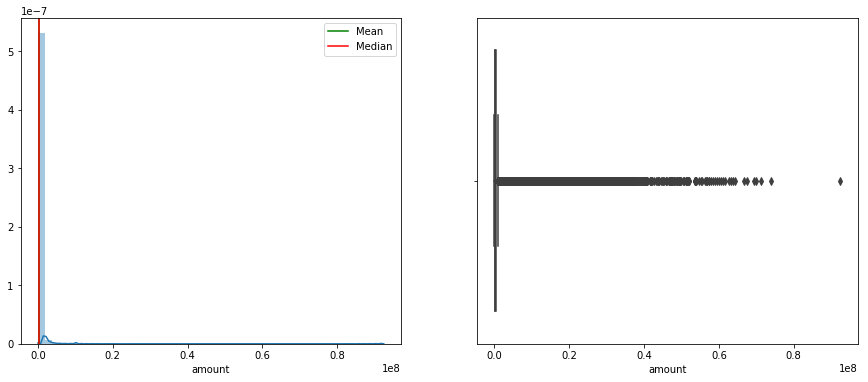

In [26]:
# summary statistics
print("Summary statistics:\n", df_new['amount'].describe().round(2))
print("-"*100)

# skewness
print("Skew: ", df_new['amount'].skew().round(2))

# shape of distribution
plt.subplots(1,2, figsize=(15,6))
# distribution using histogram
plt.subplot(1,2,1)
sns.distplot(df_new['amount'])
plt.axvline(df_new['amount'].mean(), color="g", label="Mean")
plt.axvline(df_new['amount'].median(), color="r", label="Median")
plt.legend()

# boxplot
plt.subplot(1,2,2)
sns.boxplot(df_new['amount'], whis=3)

# display plot
plt.show()

Summary statistics:
 count    2770409.00
mean           5.04
std            1.19
min            0.00
25%            4.43
50%            5.15
75%            5.73
max           11.43
Name: th_amount, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  -0.42


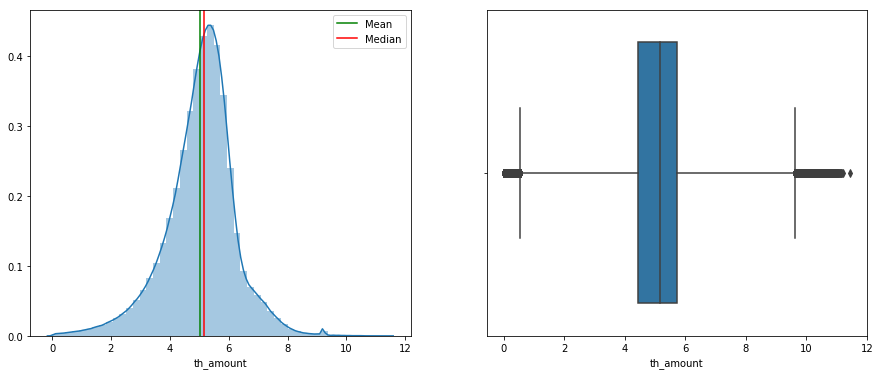

In [27]:
# summary statistics
print("Summary statistics:\n", np.log1p(df_new['th_amount']).describe().round(2))
print("-"*100)

# skewness
print("Skew: ", np.log1p(df_new['th_amount']).skew().round(2))

# shape of distribution
plt.subplots(1,2, figsize=(15,6))
# distribution using histogram
plt.subplot(1,2,1)
sns.distplot(np.log1p(df_new['th_amount']))
plt.axvline(np.log1p(df_new['th_amount']).mean(), color="g", label="Mean")
plt.axvline(np.log1p(df_new['th_amount']).median(), color="r", label="Median")
plt.legend()

# boxplot
plt.subplot(1,2,2)
sns.boxplot(np.log1p(df_new['th_amount']), whis=3)

# display plot
plt.show()

### Observations:

Applying log transformation on the amount is removing skewness.
Outliers also reduced after applying log transformation.

In [28]:
# log transformed amount
df_new['ln_amount'] = np.log1p(df_new['th_amount'])

Summary statistics:
 count     2770409.00
mean       285984.97
std        875322.99
min            -0.01
25%         51853.10
50%        143597.06
75%        279891.16
max      92445516.64
Name: errorBalanceOrig, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  22.68


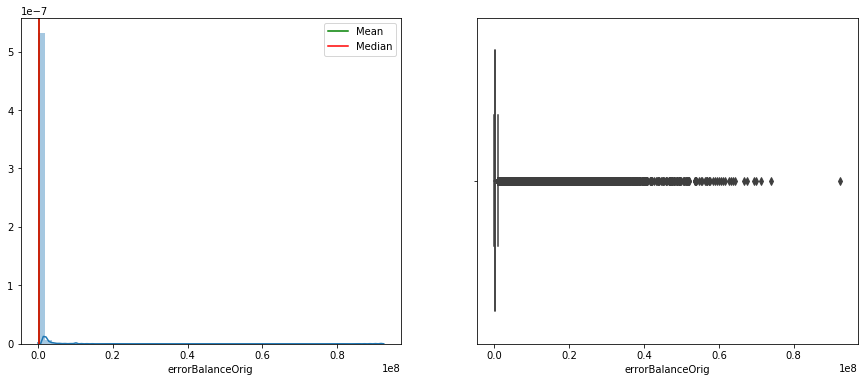

In [29]:
# summary statistics
print("Summary statistics:\n", df_new['errorBalanceOrig'].describe().round(2))
print("-"*100)

# skewness
print("Skew: ", df_new['errorBalanceOrig'].skew().round(2))

# shape of distribution
plt.subplots(1,2, figsize=(15,6))
# distribution using histogram
plt.subplot(1,2,1)
sns.distplot(df_new['errorBalanceOrig'])
plt.axvline(df_new['errorBalanceOrig'].mean(), color="g", label="Mean")
plt.axvline(df_new['errorBalanceOrig'].median(), color="r", label="Median")
plt.legend()

# boxplot
plt.subplot(1,2,2)
sns.boxplot(df_new['errorBalanceOrig'], whis=3)

# display plot
plt.show()

In [30]:
# correcting few negative errors
df_new['errorBalanceOrig'] = df_new['errorBalanceOrig'].apply(lambda x: 0 if x < 0 else x)

Summary statistics:
 count    2770409.00
mean          10.68
std            3.79
min            0.00
25%           10.86
50%           11.87
75%           12.54
max           18.34
Name: errorBalanceOrig, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  -2.18


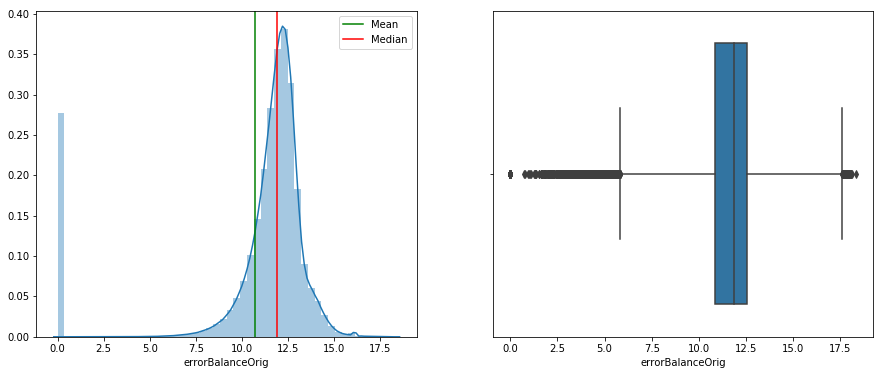

In [31]:
# summary statistics
print("Summary statistics:\n", np.log1p(df_new['errorBalanceOrig']).describe().round(2))
print("-"*100)

# skewness
print("Skew: ", np.log1p(df_new['errorBalanceOrig']).skew().round(2))

# shape of distribution
plt.subplots(1,2, figsize=(15,6))
# distribution using histogram
plt.subplot(1,2,1)
sns.distplot(np.log1p(df_new['errorBalanceOrig']))
plt.axvline(np.log1p(df_new['errorBalanceOrig']).mean(), color="g", label="Mean")
plt.axvline(np.log1p(df_new['errorBalanceOrig']).median(), color="r", label="Median")
plt.legend()

# boxplot
plt.subplot(1,2,2)
sns.boxplot(np.log1p(df_new['errorBalanceOrig']), whis=3)

# display plot
plt.show()

In [32]:
# log transformed origin account balance error
df_new['ln_errorBalanceOrig'] = np.log1p(df_new['errorBalanceOrig'])

In [33]:
#Destination account balance error
print("Summary statistics:\n", df_new['errorBalanceDest'].describe().round(2))
print("-"*100)

# skewness
print("Skew: ", df_new['errorBalanceDest'].skew().round(2))

Summary statistics:
 count     2770409.00
mean       -28647.13
std        593479.44
min     -75885725.63
25%             0.00
50%             0.00
75%             0.00
max      10000000.00
Name: errorBalanceDest, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  -44.08


In [34]:
# summary statistics
print("Summary statistics:\n", np.log1p(df_new['errorBalanceDest']).describe().round(2))
print("-"*100)

# skewness
print("Skew: ", np.log1p(df_new['errorBalanceDest']).skew().round(2))

Summary statistics:
 count    2601431.00
mean           0.46
std            2.28
min           -0.01
25%            0.00
50%            0.00
75%            0.00
max           16.12
Name: errorBalanceDest, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  4.86


In [35]:
# log transformed origin account balance error
df_new['ln_errorBalanceDest'] = np.log1p(df_new['errorBalanceDest'])

# correcting errors
df_new['ln_errorBalanceDest'] = df_new['ln_errorBalanceDest'].apply(lambda x: 0 if x < 0 else x)
df_new['ln_errorBalanceDest'].fillna(0, inplace=True)

In [36]:
#Subsetting final set of variables for modelling
df_model = df_new[['type', 'transactionPeriod',
                   'zeroBalanceOrig', 'zeroBalanceDest',
                   'ln_errorBalanceOrig', 'ln_errorBalanceDest', 'ln_amount',
                   'isFraud']]

# dataframe dimensions
print(f"The dataframe for modelling has {df_model.shape[0]} rows and {df_model.shape[1]} columns.")
print()
print("Features that are finally selected for our model:\n", list(df_model.columns)[:-1])

The dataframe for modelling has 2770409 rows and 8 columns.

Features that are finally selected for our model:
 ['type', 'transactionPeriod', 'zeroBalanceOrig', 'zeroBalanceDest', 'ln_errorBalanceOrig', 'ln_errorBalanceDest', 'ln_amount']


In [38]:
df_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,th_amount,transactionBetween,transactionPeriod,errorBalanceOrig,errorBalanceDest,zeroBalanceOrig,zeroBalanceDest,ln_amount,ln_errorBalanceOrig,ln_errorBalanceDest
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,...,0.181,Customer2Customer,Mid,0.0,181.0,0,1,0.166362,0.0,5.204007
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,...,0.181,Customer2Customer,Mid,0.0,21363.0,0,0,0.166362,0.0,9.969463
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,...,2.806,Customer2Customer,Mid,0.0,2806.0,0,1,1.336579,0.0,7.939872
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,...,2.806,Customer2Customer,Mid,0.0,29008.0,0,0,1.336579,0.0,10.275361
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,...,20.128,Customer2Customer,Mid,0.0,20128.0,0,1,3.050599,0.0,9.909917


In [40]:
df_model

,type,transactionPeriod,zeroBalanceOrig,zeroBalanceDest,ln_errorBalanceOrig,ln_errorBalanceDest,ln_amount,isFraud
2,TRANSFER,Mid,0,1,0.000000,5.204007,0.166362,1
3,CASH_OUT,Mid,0,0,0.000000,9.969463,0.166362,1
251,TRANSFER,Mid,0,1,0.000000,7.939872,1.336579,1
252,CASH_OUT,Mid,0,0,0.000000,10.275361,1.336579,1
680,TRANSFER,Mid,0,1,0.000000,9.909917,3.050599,1
...,...,...,...,...,...,...,...,...
6362313,CASH_OUT,Mid,0,0,11.584788,0.000000,4.727067,0
6362317,CASH_OUT,Mid,0,0,12.666684,0.000000,5.762609,0
6362320,CASH_OUT,Mid,0,0,11.953309,0.000000,5.076349,0
6362321,CASH_OUT,Mid,0,0,9.810760,0.000000,5.232572,0


isFraud
0    [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
dtype: object

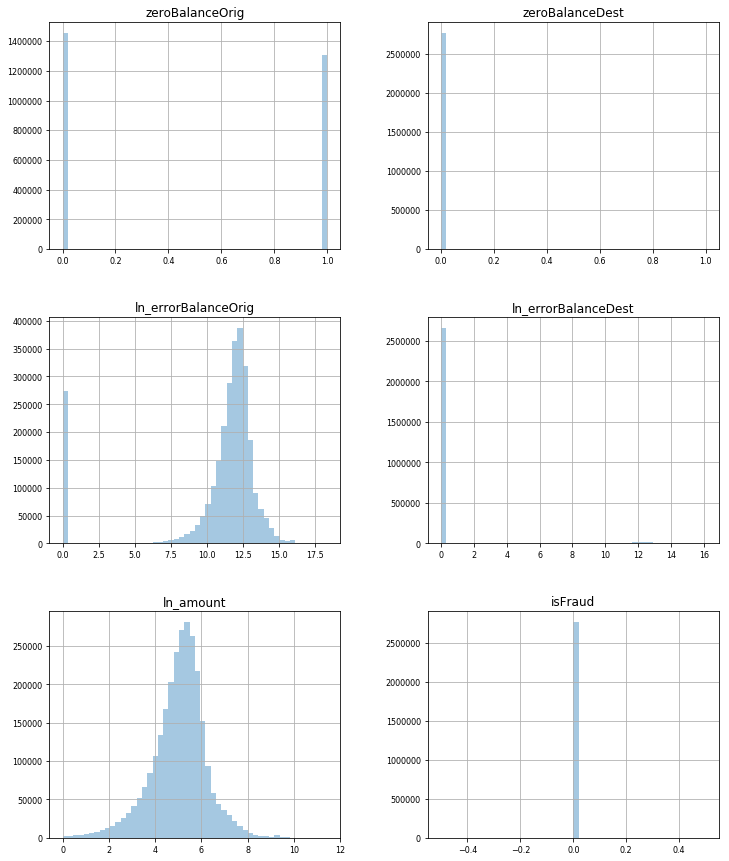

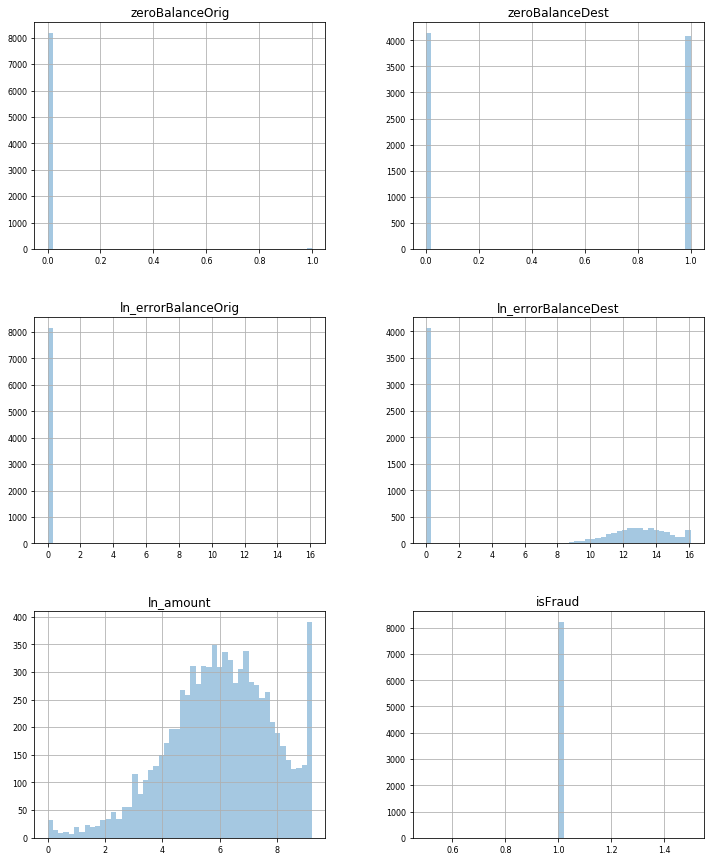

In [43]:
''' Visualising the variables by grouping them by class '''
df_model.groupby('isFraud').hist(figsize=(12, 15), bins=50, xlabelsize=8, ylabelsize=8,alpha=0.4)

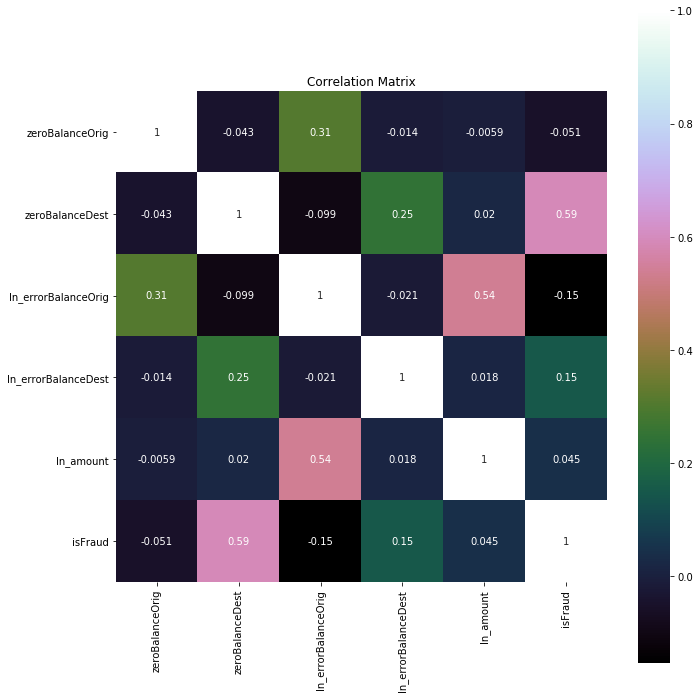

In [44]:
''' co-relation matrix to check multicolinearity between variables '''

correlation = df_model.corr()
plt.figure(figsize=(11,12))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

In [45]:
# identifying dependent and independent features
X = df_model.loc[:, :'ln_amount']
y = df_model['isFraud']

# splitting data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [46]:
X.head(10)

,type,transactionPeriod,zeroBalanceOrig,zeroBalanceDest,ln_errorBalanceOrig,ln_errorBalanceDest,ln_amount
2,TRANSFER,Mid,0,1,0.000000,5.204007,0.166362
3,CASH_OUT,Mid,0,0,0.000000,9.969463,0.166362
251,TRANSFER,Mid,0,1,0.000000,7.939872,1.336579
252,CASH_OUT,Mid,0,0,0.000000,10.275361,1.336579
680,TRANSFER,Mid,0,1,0.000000,9.909917,3.050599
681,CASH_OUT,Mid,0,0,0.000000,9.564593,3.050599
724,CASH_OUT,Mid,1,0,12.938446,0.000000,6.033089
969,TRANSFER,Mid,0,1,0.000000,14.060192,7.153218
970,CASH_OUT,Mid,0,0,0.000000,0.000000,7.153218
1115,TRANSFER,Mid,0,1,0.000000,10.464948,3.585285


In [55]:
y.head(10)

2       1
3       1
251     1
252     1
680     1
681     1
724     1
969     1
970     1
1115    1
Name: isFraud, dtype: int64

In [51]:
y.value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

In [56]:
# creating train and test dataframes
df_train = X_train
df_train['isFraud'] = y_train

df_test = X_test
df_test['isFraud'] = y_test

In [64]:
df_train

,type,transactionPeriod,zeroBalanceOrig,zeroBalanceDest,ln_errorBalanceOrig,ln_errorBalanceDest,ln_amount,isFraud
3396930,CASH_OUT,Safe,0,0,10.387759,0.000000e+00,3.886707,0
1760787,CASH_OUT,Safe,0,0,10.894999,1.455192e-11,4.008262,0
119349,CASH_OUT,Safe,0,0,12.550709,0.000000e+00,6.739697,0
5868234,CASH_OUT,Safe,0,0,12.022349,9.950331e-03,5.150531,0
1302704,TRANSFER,Safe,1,0,13.509893,0.000000e+00,6.603493,0
...,...,...,...,...,...,...,...,...
953769,CASH_OUT,Safe,0,0,0.000000,0.000000e+00,3.579197,0
199079,CASH_OUT,Safe,0,0,9.568945,1.171850e+01,4.720019,0
4275408,CASH_OUT,Safe,0,0,0.000000,0.000000e+00,0.913471,0
5465099,CASH_OUT,Safe,1,0,10.894771,0.000000e+00,4.005383,0


In [63]:
df_test

,type,transactionPeriod,zeroBalanceOrig,zeroBalanceDest,ln_errorBalanceOrig,ln_errorBalanceDest,ln_amount,isFraud
365806,CASH_OUT,Safe,0,0,10.695699,1.206132e+01,4.122000,0
2125856,CASH_OUT,Safe,0,0,12.737391,0.000000e+00,6.049466,0
6215823,CASH_OUT,Safe,0,0,11.261479,0.000000e+00,4.876590,0
1188775,CASH_OUT,Safe,0,0,11.597704,5.820766e-11,4.789802,0
5944609,CASH_OUT,Safe,1,0,12.449247,9.950331e-03,5.545401,0
...,...,...,...,...,...,...,...,...
4020061,CASH_OUT,Safe,1,0,11.852817,9.950331e-03,4.952148,0
3772293,CASH_OUT,Safe,1,0,12.181824,0.000000e+00,5.279173,0
428475,TRANSFER,Safe,1,0,11.272093,1.147492e+01,4.376968,0
241620,CASH_OUT,Safe,1,0,11.650658,0.000000e+00,4.751570,0


In [65]:
# down-sampling majority class
df_train_downsampled = df_train[df_train['isFraud'] == 0].sample(250000, random_state=1)

In [68]:
# appending the fraud data
df_train_downsampled = pd.concat([df_train_downsampled, df_train[df_train['isFraud'] == 1]])

# dataframe dimensions
print(f"After downsampling the majority class, imbalanced train set has {df_train_downsampled.shape[0]} rows and {df_train_downsampled.shape[1]} columns.")

After downsampling the majority class, imbalanced train set has 256570 rows and 8 columns.


In [72]:
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))


print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

'''resampling the training data'''

# preprocessing data for SMOTE
X_train_smote = df_train_downsampled[['zeroBalanceOrig', 'zeroBalanceDest', 'ln_errorBalanceOrig', 'ln_errorBalanceDest', 'ln_amount']].round(3)

X_train_smote['type_Transfer'] = df_train_downsampled['type'].replace({'CASH_OUT' : 0,
                                                                       'TRANSFER' : 1})

X_train_smote['transactionPeriod_Mid'] = df_train_downsampled['transactionPeriod'].apply(lambda x: 1 if x == 'Mid' else 0)
X_train_smote['transactionPeriod_Peak'] = df_train_downsampled['transactionPeriod'].apply(lambda x: 1 if x == 'Peak' else 0)
#print(X_train_smote)

# initializing SMOTE object
smote = SMOTE(random_state=33)

# fitting data with SMOTE and creating synthetic over-sampled data set
X, y = smote.fit_sample(X_train_smote, df_train_downsampled['isFraud'])

print("After OverSampling, counts of label '1': {}".format(sum(y==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y==0)))


# concatnating data and creating train df
df_train_downsampled_smote = pd.concat([X, y], axis=1)

# shuffling data
df_train_downsampled_smote = df_train_downsampled_smote.sample(frac=1, random_state=1)

# dataframe dimensions
print(f"After downsampling the majority class and upsampling the minority class using SMOTE, the balanced train set has {df_train_downsampled_smote.shape[0]} rows and {df_train_downsampled_smote.shape[1]} columns.")

After OverSampling, the shape of train_X: (2216327, 8)
After OverSampling, the shape of train_y: (2216327,) 

Before OverSampling, counts of label '1': 6570
Before OverSampling, counts of label '0': 2209757 

After OverSampling, counts of label '1': 250000
After OverSampling, counts of label '0': 250000
After downsampling the majority class and upsampling the minority class using SMOTE, the balanced train set has 500000 rows and 9 columns.


In [74]:
''' Feature scaling '''
from sklearn.preprocessing import StandardScaler
# initializing standard scaler
ss = StandardScaler()

# fitting scaler on train data
ss.fit(df_train_downsampled[['ln_errorBalanceOrig','ln_errorBalanceDest','ln_amount']])


StandardScaler()

In [80]:
# df_train_downsampled_smote
# standardizing train data
X_train_downsampled_smote = pd.DataFrame(ss.transform(df_train_downsampled_smote[['ln_errorBalanceOrig','ln_errorBalanceDest','ln_amount']]),
                                         columns=['ln_errorBalanceOrig','ln_errorBalanceDest','ln_amount'])

# dummies
X_train_downsampled_smote['zeroBalanceOrig'] = df_train_downsampled_smote['zeroBalanceOrig'].reset_index(drop=True)
X_train_downsampled_smote['zeroBalanceDest'] = df_train_downsampled_smote['zeroBalanceDest'].reset_index(drop=True)
X_train_downsampled_smote['type_Transfer'] = df_train_downsampled_smote['type_Transfer'].reset_index(drop=True)
X_train_downsampled_smote['transactionPeriod_Mid'] = df_train_downsampled_smote['transactionPeriod_Mid'].reset_index(drop=True)
X_train_downsampled_smote['transactionPeriod_Peak'] = df_train_downsampled_smote['transactionPeriod_Peak'].reset_index(drop=True)

# target variable
y_train_downsampled_smote = df_train_downsampled_smote['isFraud'].reset_index(drop=True)


In [75]:
# standardizing test data
X_test = pd.DataFrame(ss.transform(df_test[['ln_errorBalanceOrig','ln_errorBalanceDest','ln_amount']]),
                      columns=['ln_errorBalanceOrig','ln_errorBalanceDest','ln_amount'])

# creating dummies for test data
X_test['zeroBalanceOrig'] = df_test['zeroBalanceOrig'].reset_index(drop=True)
X_test['zeroBalanceDest'] = df_test['zeroBalanceDest'].reset_index(drop=True)

X_test['type_Transfer'] = df_test['type'].replace({'CASH_OUT' : 0,
                                                   'TRANSFER' : 1})\
                                         .reset_index(drop=True)

X_test['transactionPeriod_Mid'] = df_test['transactionPeriod'].apply(lambda x: 1 if x == 'Mid' else 0)\
                                                              .reset_index(drop=True)
X_test['transactionPeriod_Peak'] = df_test['transactionPeriod'].apply(lambda x: 1 if x == 'Peak' else 0)\
                                                               .reset_index(drop=True)


In [77]:
# target variable
y_test = df_test['isFraud'].reset_index(drop=True)

In [81]:
# shuffling data

X_train_downsampled_smote = X_train_downsampled_smote.sample(frac=1, random_state=33)
y_train_downsampled_smote = y_train_downsampled_smote.sample(frac=1, random_state=33)

### Logistic Regression

In [83]:

from sklearn.linear_model import LogisticRegression
clf=LogisticRegression()
clf.fit(X_train_downsampled_smote, y_train_downsampled_smote)
preds=clf.predict(X_test)
print('accuracy with Logistic Regression:',accuracy_score(y_test, preds), '%')


accuracy with Logistic Regression: 0.9337895834912522 %


# Random Forest


In [93]:
from sklearn.ensemble import RandomForestClassifier
rf_clf=RandomForestClassifier()
rf_clf.fit(X_train_downsampled_smote, y_train_downsampled_smote)
preds=rf_clf.predict(X_test)
print('accuracy with Random Forest:',accuracy_score(y_test, preds), '%')

accuracy with Random Forest: 0.9177378077613061 %


In [88]:

''' Generating the Confusion matrix and Classification report'''

print('Confusion matrix', '\n', confusion_matrix(y_test, preds), '\n')
print('Classification report', '\n', classification_report(y_test, preds), '\n')

Confusion matrix 
 [[507504  44935]
 [    85   1558]] 

Classification report 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96    552439
           1       0.03      0.95      0.06      1643

    accuracy                           0.92    554082
   macro avg       0.52      0.93      0.51    554082
weighted avg       1.00      0.92      0.95    554082
 



In [96]:
x_new=np.reshape(np.asarray([0.00,0.00,0.19,0,0,0,0,1]),(1,8))
#x_new_scaled = sc.fit_transform(x_new)
y_pred =clf.predict(x_new)
print(y_pred)
if y_pred==0:
    print("Transaction done is fraudulant")
else:
    print("No Money Laundering!")
    

[0]
Transaction done is fraudulant


Conclusions
Fraud is a very rare event, approximately only 1 in 1,000 transactions is a fraudulent. Identifying fraudulent transactions could be challenging due to its highly rare nature.

Where does fraud happen?

Fraud is observed in Cash Out and Transfer type transactions only.
Also, fraud is observed in Customer 2 Customer transactions only.
When does fraud happend?

Majority of fraudulent transactions happen during night.
Fraudulent transactions peak between 3am and 6am, and goes as high as 58% of transactions.
Less than 1% of transactions during day are fraudulent.
Characteristics of fraudulent transaction amount:

Proportion of fraudulent transactions in case of transaction amount ending in 0 is little higher than rest of the digits.
Human beings tend to come up with round numbers when they make-up numbers.
Cues to identify fraudulent transactions:

Proportion of fraudulent transactions in case of transaction amount ending in 0 is little higher than rest of the digits.
Human beings tend to come up with round numbers when they make-up numbers.
Important features for fraud detection model:

zeroBalanceDest: Whether the destination account balance amount after the transaction was zero.
ln_errorBalanceOrig: Log of error in the origin account balance amount after the transaction.
transactionPeriod_Peak: Whether the transaction was made during peak fraudulent transaction period (midnight).